1️⃣ Notebook Setup Cell

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import faiss
import random

plt.rcParams["figure.figsize"] = (12, 6)


2️⃣ Load Metadata & Embeddings

In [2]:
# Load metadata
df = pd.read_csv("../data/processed/metadata.csv", dtype={"product_id": str})
df = df.set_index("product_id")

# Load embeddings
emb_resnet = np.load("../artifacts/resnet/embeddings.npy")
ids_resnet = np.load("../artifacts/resnet/product_ids.npy").astype(str)

emb_clip = np.load("../artifacts/clip/embeddings.npy")
ids_clip = np.load("../artifacts/clip/product_ids.npy").astype(str)


In [9]:
df.head()

,source,image_path,category,brand,price,currency,ingestion_timestamp
product_id,,,,,,,
15970,kaggle,data/processed/images/15970.jpg,Shirts,NaN,NaN,NaN,2025-12-15T15:54:08.614982
39386,kaggle,data/processed/images/39386.jpg,Jeans,NaN,NaN,NaN,2025-12-15T15:54:08.631509
59263,kaggle,data/processed/images/59263.jpg,Watches,NaN,NaN,NaN,2025-12-15T15:54:08.658489
21379,kaggle,data/processed/images/21379.jpg,Track Pants,NaN,NaN,NaN,2025-12-15T15:54:08.682405
53759,kaggle,data/processed/images/53759.jpg,Tshirts,NaN,NaN,NaN,2025-12-15T15:54:08.697531


In [3]:
assert len(ids_resnet) == len(emb_resnet)
assert len(ids_clip) == len(emb_clip)

3️⃣ Build FAISS Indexes (One-Time per Notebook)

In [ ]:
def build_index(embeddings):
    dim = embeddings.shape[1]
    index = faiss.IndexFlatIP(dim)
    index.add(embeddings.astype("float32"))
    return index

index_resnet = build_index(emb_resnet)
index_clip = build_index(emb_clip)

4️⃣ Helper: Display Image Grid

In [5]:
# def show_images(image_paths, title):
#     n = len(image_paths)
#     fig, axes = plt.subplots(1, n)
#     fig.suptitle(title, fontsize=14)

#     for ax, path in zip(axes, image_paths):
#         img = Image.open(path).convert("RGB")
#         ax.imshow(img)
#         ax.axis("off")

#     plt.show()
def show_images(image_paths, title):
    n = len(image_paths)
    fig, axes = plt.subplots(1, n)
    fig.suptitle(title, fontsize=14)

    # Ensure axes is iterable
    if n == 1:
        axes = [axes]

    for ax, path in zip(axes, image_paths):
        img = Image.open(path).convert("RGB")
        ax.imshow(img)
        ax.axis("off")

    plt.show()



5️⃣ Retrieve Top-K Similar Products

In [6]:
def get_similar(query_pid, embeddings, ids, index, k=5):
    q_idx = np.where(ids == query_pid)[0][0]
    q_emb = embeddings[q_idx:q_idx+1]

    scores, neighbors = index.search(q_emb.astype("float32"), k+1)
    neighbor_ids = ids[neighbors[0][1:]]  # exclude self
    return neighbor_ids


6️⃣ Side-by-Side Comparison Cell (CORE)

In [7]:
query_pid = random.choice(ids_clip.tolist())
print("Query product:", query_pid)


Query product: 33528


In [10]:
query_img

'data/processed/images/33528.jpg'

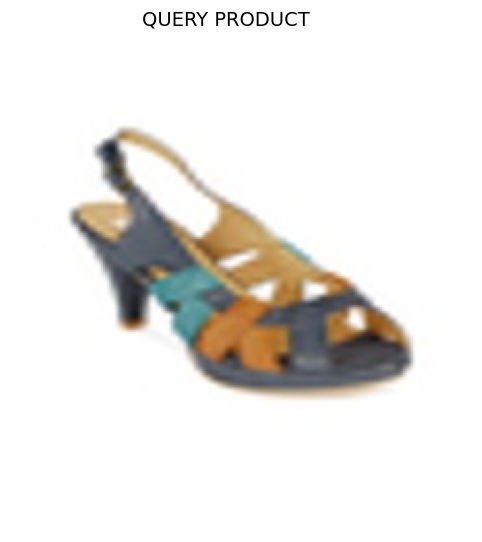

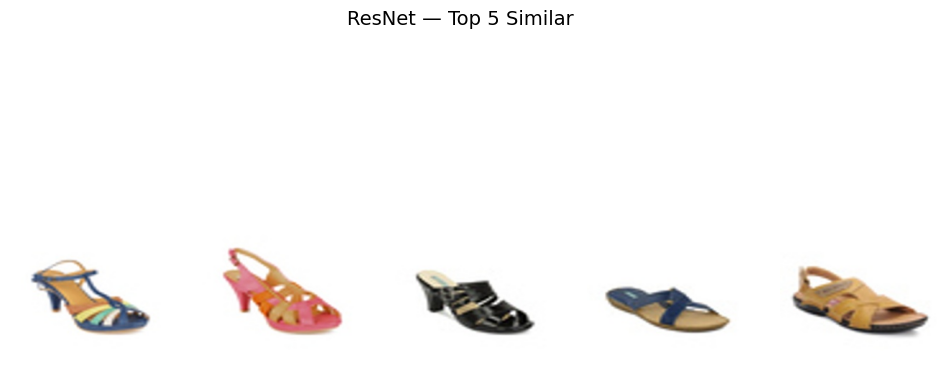

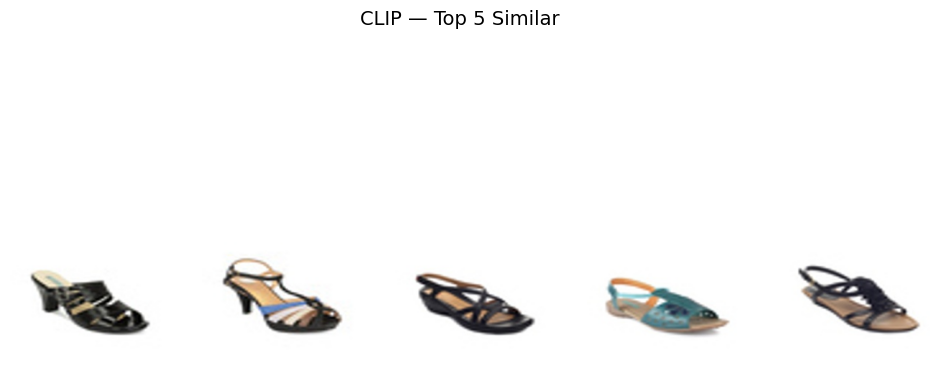

In [13]:
# Query image
query_img = "../"+df.loc[query_pid]["image_path"]
show_images([query_img], "QUERY PRODUCT")

# ResNet results
resnet_neighbors = get_similar(
    query_pid, emb_resnet, ids_resnet, index_resnet, k=5
)
resnet_imgs = ["../"+df.loc[pid]["image_path"] for pid in resnet_neighbors]
show_images(resnet_imgs, "ResNet — Top 5 Similar")

# CLIP results
clip_neighbors = get_similar(
    query_pid, emb_clip, ids_clip, index_clip, k=5
)
clip_imgs = ['../'+df.loc[pid]["image_path"] for pid in clip_neighbors]
show_images(clip_imgs, "CLIP — Top 5 Similar")


7️⃣ What You Are ACTUALLY Evaluating (Read This Carefully)

For each row, ask only these questions:

✅ Acceptable similarity if:

Same clothing type (dress ↔ dress, shoe ↔ shoe)

Similar usage (formal / casual)

Similar silhouette or pattern

❌ Reject if:

Same color but different item type

Same texture but wrong category

Accessory vs apparel confusion

Do not reward same color automatically.

8️⃣ Add a Simple Scoring (Optional but Powerful)

In [14]:
def score_neighbors(neighbor_ids, query_cat):
    scores = []
    for pid in neighbor_ids:
        cat = df.loc[pid]["category"]
        if cat == query_cat:
            scores.append(2)
        else:
            scores.append(1)  # visually similar but different category
    return sum(scores) / (2 * len(scores))


In [15]:
query_cat = df.loc[query_pid]["category"]

print("ResNet score:",
      score_neighbors(resnet_neighbors, query_cat))

print("CLIP score:",
      score_neighbors(clip_neighbors, query_cat))


ResNet score: 0.9
CLIP score: 1.0


In [21]:
import os
import pandas as pd

df = pd.read_csv("../data/processed/metadata.csv")

missing = []
for _, row in df.iterrows():
    if not os.path.exists(row["image_path"]):
        missing.append(row["product_id"])

print("Missing images:", len(missing))
print("Sample missing IDs:", missing[:10])


Missing images: 44419
Sample missing IDs: [15970, 39386, 59263, 21379, 53759, 1855, 30805, 26960, 29114, 30039]


In [20]:
from pathlib import Path

PROJECT_ROOT = Path(__file__).resolve().parents[2]
PROJECT_ROOT

NameError: name '__file__' is not defined

In [ ]:

# df_clean = df[df["image_path"].apply(os.path.exists)].copy()

# print("Before:", len(df))
# print("After:", len(df_clean))


Before: 44419
After: 0


In [22]:
df_clean = df[df["image_path"].apply(os.path.exists)]
df_clean.to_csv("../data/processed/metadata.csv", index=False)